# Dissipative spin bath
In this tutorial we will go over the steps needed to simulate the decoherence of a central spin coupled to a dissipative, interacting spin baths governed by Lindblad Master equation using CCE method (ME-CCE) within the **PyCCE** module. Two methods of interest include:

* Master Equation CCE (ME-CCE).
* Master Equation gCCE (ME-gCCE).

$\newcommand{\bra}[1]{\left\langle {#1} \right|}$
$\newcommand{\ket}[1]{\left| {#1} \right\rangle}$
$\newcommand{\Tr}{\mathrm{Tr}}$

The Lindblad master equation of the overall system can be written as:

\begin{equation}
\frac{d}{dt} \hat \rho=-\frac{i}{\hbar}[\hat H, \hat \rho]+\sum_i{\gamma_i (\hat L_i \hat \rho \hat L_i^\dagger - \frac{1}{2}\{\hat L_i^\dagger \hat L_i, \hat \rho \})},
\end{equation}

where $\hat \rho$ is the density matrix of the system, $\hat H$ is the Hamiltonian, and $\hat L_i$ are jump operators with corresponding dissipation rates $\gamma_i$.

Within the conventional CCE framework, the coherence of the central spin is recovered from the trace of the partial inner product $\hat \rho_{01} (t) =\bra{0}\hat \rho (t)\ket{1}$ as $\mathcal{L}(t)=\Tr [\hat \rho_{01} (t)]/\Tr [\hat \rho_{01} (0)]$. The evolution of  $\hat \rho_{01}$ by solving the following:

\begin{equation}
\frac{d}{dt} \hat \rho_{01} (t) = \mathfrak{I} \cdot \hat \rho_{01} (t)= -\frac{i}{\hbar} \hat H^{(0)} \hat \rho_{01}(t)  + \frac{i}{\hbar} \hat \rho_{01}(t) \hat H^{(1)} +  \sum_i{\gamma_i (\hat L_i \hat \rho \hat L_i^\dagger - \frac{1}{2}\{\hat L_i^\dagger \hat L_i, \hat \rho \})},
\end{equation}

Within the generalized CCE framework, one needs to solve full Lindbladian for each cluster including central spin.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pycce as pc

## Setup the simulator properties

As an example we consider the dissipative electron spin bath. First, we generate electron spin bath with concentration $\rho=10^{16}$ cm$^{-3}$ 

In [ ]:
electrons = pc.random_bath('e', [5e3, 5e3, 5e3], density=1e16,
                         density_units='cm-3', seed=2)  # Density in 1/cm^3

The properties of the central spin-1/2 are stored in the `CenterArray`.

In [3]:
center = pc.CenterArray(spin=1/2, alpha=[1,0], beta=[0,1])
print(center)

CenterArray
(s: [0.5],
xyz:
[[0. 0. 0.]],
zfs:
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]],
gyro:
[[[-17608.59705     -0.          -0.     ]
  [    -0.      -17608.59705     -0.     ]
  [    -0.          -0.      -17608.59705]]])


 To run the simulations we need to setup the `Simulator` object.

In [4]:
calc = pc.Simulator(center, bath=electrons, order=2, r_bath=1.4e3, r_dipole=0.7e3, pulses=1, magnetic_field=300, n_clusters=None)
print(calc)

Simulator for center array of size 1.
magnetic field:
array([  0.,   0., 300.])

Parameters of cluster expansion:
r_bath: 1400.0
r_dipole: 700.0
order: 2

Bath consists of 104 spins.

Clusters include:
104  clusters of order 1.
539  clusters of order 2.



As a reference we compute the coherence with conventional CCE assuming no dissipation:

Text(0.5, 0, 'Time (ms)')

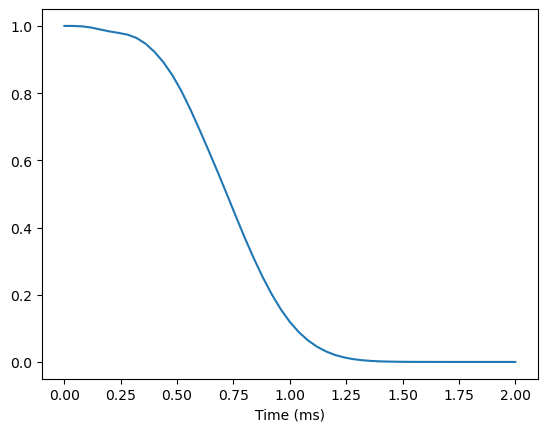

In [5]:
ts = np.linspace(0, 2, 51)
lcce = calc.compute(ts, method='cce')
plt.plot(ts, lcce.real)
plt.xlabel('Time (ms)')

## Dissipation in the bath

In this example we assume that each electron spin in the bath decays into completely random state with the characteristic decay time $T_1=0.5$ ms.
To add dissipation we use the method `.add_single_jump` method of the `calc.bath` object. Note because we have a single bath type (same name of all spins) the `which` keyword of the method is unnecessary.

In [6]:
et1 = 0.5  # in ms 
decay_rate = 1 / et1 / 2  # in rad / ms
calc.bath.add_single_jump('p', rate=decay_rate)  # p for creation operator S+ 
calc.bath.add_single_jump('m', rate=decay_rate)  # m for annihilation operator S-

The dissipators are stored in the `.so` attribute of the given spin type in the units of $kHz^{1/2}$ 
(square root to match how one sets up the simulations in the Qutip, but note that it's not in radial frequencies):

In [7]:
calc.bath['e'].so

{'p': 0.3989422804014327, 'm': 0.3989422804014327}

We can compute the coherence with ME-CCE to account for these dissipative dynamics:

In [8]:
lmecce = calc.compute(ts, method='mecce')

calc.order = 1
lmecce_1 = calc.compute(ts, method='mecce') # Coherence at first order

By comparing the full calculation with ME-CCE to the product of ME-CCE calculation of first order (ME-CCE1) and CCE2 we can directly see the interplay between single spin incoherent dynamics and the coherent flips:

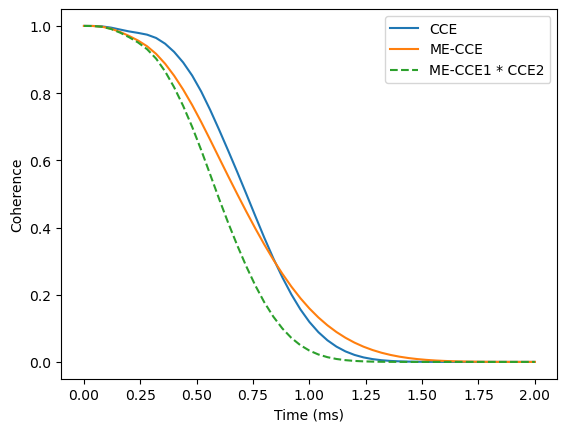

In [9]:
plt.plot(ts, lcce.real, label='CCE')
plt.plot(ts, lmecce.real, label='ME-CCE')
plt.plot(ts, (lmecce_1 * lcce).real, ls='--', label='ME-CCE1 * CCE2')

plt.xlabel('Time (ms)')
plt.ylabel('Coherence')

plt.legend();

We find that the exact accounting for both coherent and incoherent processes leads to a singificantly different qualitative behaviour of the coherence.

## Dissipation in the central spin
To account for the central spin coupling to its own Markovian bath we need to use gCCE flavor of the ME approach.

We set up the dissipation on the central spin in the similar way as the bath spins, by calling  `.add_single_jump` method of the `calc.center` object. As an example, consider pure dephasing of the central spin due to the Markovian environment.

In [10]:
t2 = 1  # in ms 
decay_rate = 2 / t2 # in rad / ms
calc.bath['e'].so.clear() # Remove bath spin dissipators
calc.center.add_single_jump('z', rate=decay_rate)  # z for operator Sz 
calc.center[0].detuning = 1e6 # Detune central spin from the spin bath

In [11]:
calc.order = 2
lmegcce = calc.compute(ts, method='megcce', pulses=1)

And now we show that central spin dissipators are trivial to deal with and can be factorized out. We can divide the obtained coherence curve by the expected markovian dephasing, and recover the coherence curve limited purely by the interactions with the bath.

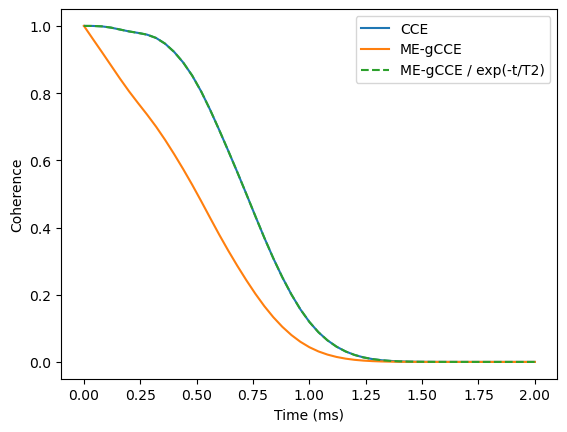

In [12]:
plt.plot(ts, np.abs(lcce), label='CCE')
plt.plot(ts, np.abs(lmegcce), label='ME-gCCE')
plt.plot(ts, np.abs(lmegcce) / np.exp(-ts/t2), ls='--', label='ME-gCCE / exp(-t/T2)')

plt.xlabel('Time (ms)')
plt.ylabel('Coherence')

plt.legend();

Note that calculations with the ME-based methods are significantly more expensive, as we need to solve the eigenvalue problem for the $N^4$ matrix 
where $N$ is the size of the Hilbert space, compared to $N^2$ in the case of the closed system.